In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2, json, torch, os, re

import util, constants, draw, cam, model, loader, img_proc

np.random.seed(0)
torch.manual_seed(0)

VID_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/harden/'
DATA_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/'

img_shape_yx = plt.imread(VID_ROOT+'/all_views/frame_00001.png').shape[:2];img_shape_xy = img_shape_yx[::-1]

uf_mat_int_default = cam.get_mat_intrinsic()
uf_mat_int = cam.get_intrinsic_mat_for_img_shape(img_shape_xy)

with open(VID_ROOT+'/md.json') as f:
    data = json.load(f)
    num_views, num_frames = data['num_views'], data['num_frames']
    
print(f'{num_views} views, {num_frames} frames')
print(f'img_shape_xy: {img_shape_xy}')

3 views, 90 frames
img_shape_xy: (1280, 720)


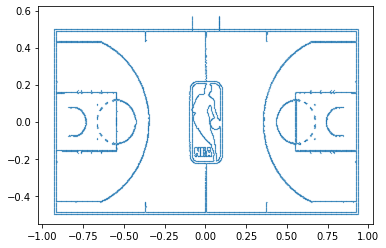

In [3]:
img = plt.imread(VID_ROOT+'/view_0/frame_00089.png')
img = (img*255/img.max()).astype(np.uint8)

court_img, court_bin = model.load_model_img(DATA_ROOT)
court_img = (court_img*255/court_img.max()).astype(np.uint8)

mat_model = model.get_mat_model(model.load_model_corners(DATA_ROOT))

X_w = model.calc_model_world_coordinates(DATA_ROOT)
plt.scatter(X_w[:, 0], X_w[:, 1], marker='.', s=0.1);plt.show()

In [4]:
kp, confs, scores, boxes = loader.load_alphapose_kp('/home/akarshkumar0101/nba-3d-data/harden/', 90)
imgs_data = loader.load_data_imgs(VID_ROOT, range(num_views), [0])

In [23]:
dofs_cam_0 = np.load(VID_ROOT+'/dofs_cam_first_frame.npy')

In [13]:
with open(VID_ROOT+'/score_box_loc.json') as f:
    score_box = np.array(json.load(f))
score_box

array([[ 254,  585],
       [1026,  693]])

# Loss function

In [124]:
"""
alpha= 0.0 will take the mean.
alpha= 0.2 will be very close to max.
alpha=-0.2 will be very close to min.
"""
def smooth_max(x, alpha, dim=-1):
    # unstable version:
    # return (x*(alpha*x).exp()).sum()/((alpha*x).exp()).sum()
    return ((alpha*x).softmax(dim=dim)*x).sum(dim=dim)

def pt2pt_dist(p1, p2):
    # (..., N1, D) and (..., N2, D)
    return (p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1).min(dim=-1).values

def pt2pt_dist_ind(p1, p2):
    # (..., N1, D) and (..., N2, D)
    return (p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1).min(dim=-1).indices

def pt2pt_dist_soft(p1, p2, alpha=-.2):
    # (..., N1, D) and (..., N2, D)
    return smooth_max((p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1), alpha=alpha, dim=-1)

def fitness(dofs_cam, X_i_true):
    X_i, vis_mask = cam.project_to_cam(X_w_down, dofs_cam)
    X_i = X_i[vis_mask]
    if(X_i.shape[0]==0):
        return np.inf
    p = X_i.shape[0] / X_w_down.shape[0]
    loss_vis = -np.log(p)
    loss_pt2pt = pt2pt_dist(X_i, X_i_true).mean().item()
    loss_small_f = (-dofs_cam[..., 6]).exp().mean().item()
#     print(loss_vis, loss_pt2pt, loss_small_f)
    return loss_vis+loss_pt2pt+loss_small_f

# Energy Minimization with Population Based Search

In [ ]:
import cma

In [ ]:
torch.manual_seed(0)
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample()
# x[6] = 1.
# x[7] = 0.

dofs_cam_true, _ = gaussian2cam(x)

In [ ]:
draw.show_cam_view(X_w_down, dofs_cam_true)

In [ ]:
X_i_true, vis_mask = cam.project_to_cam(X_w_down, dofs_cam_true)
X_i_true = X_i_true[vis_mask]

In [ ]:
es = cma.CMAEvolutionStrategy(8*[0], 1.0)
i = 0
while not es.stop():
    solutions = es.ask(100)
    print(i)
#     for x in solutions:
#         x[6] = 1.
#         x[7] = 0.
    fitnesses = [fitness(gaussian2cam(torch.tensor(x).float())[0], X_i_true) for x in solutions]
    es.tell(solutions, fitnesses)
#     es.logger.add()
#     es.disp()
    i+=1
    if i%1==0:
        draw.show_cam_view(X_w, dofs_cam_true, label='ground truth')
        draw.show_cam_view(X_w, gaussian2cam(torch.tensor(es.best.x).float())[0], label='best so far')
        plt.legend(bbox_to_anchor=(1.4, 1.))
        plt.show()

In [ ]:
x_true = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample()
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample((1000,))


dists = (x-x_true).norm(dim=-1)
plt.hist(dists.numpy())

In [ ]:
# es.result_pretty()
# cma.plot()

# Energy Minimization with Supervised Rendering Loss


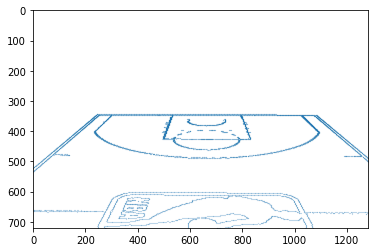

In [178]:
X_i, viz_mask = cam.project_to_cam(X_w, dofs_cam, img_shape_xy)
plt.scatter(X_i[2, 0, :, 0], X_i[2, 0, :, 1], s=0.01)
draw.set_img_bounds(img_shape_xy)

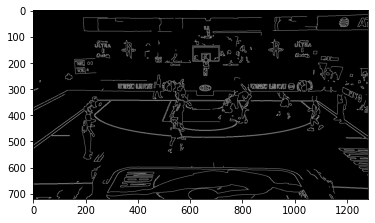

In [179]:
plt.imshow(img_proc.process_img_canny(imgs_data[2,0]), cmap='gray')

In [33]:
dofs_cam.shape

(3, 1, 7)

In [186]:
img_data = img_proc.process_img_canny(imgs_data[2, 9].mean(axis=-1), ep=False)
X_i_gt = np.stack(np.where(img_data>128)[::-1], axis=-1)
X_i_gt = torch.from_numpy(X_i_gt[::10])

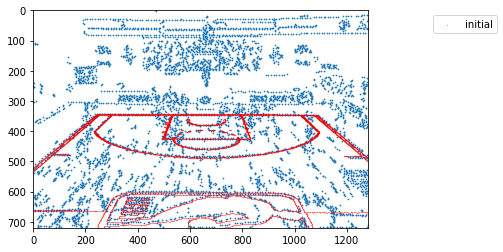

In [187]:
dofs_cam_optim = torch.from_numpy(dofs_cam[2, 0, :])

plt.scatter(X_i_gt[:, 0], X_i_gt[:, 1], cmap='gray', s=0.5)
draw.set_img_bounds(img_shape_xy)
draw.show_cam_view(X_w, dofs_cam_optim.detach().numpy(), img_shape_xy, label='initial', c='r', s=0.1)
plt.legend(bbox_to_anchor=(1.4, 1.))

In [ ]:
X_w = torch.from_numpy(X_w)

In [72]:
"""
Randomly sample the Pytorch Tensor `a` along axis `axis` `numsamples` times.
"""
def rand_sample(a, num_sample, dim=0, ret_sample_mask=False):
    a = a.transpose(0, dim)
    sample_mask = torch.randperm(a.shape[0])[:num_sample]
    a = a[sample_mask]
    a = a.transpose(0, dim)
    return (a, ret_sample_mask) if ret_sample_mask else a

In [232]:
def optimize_dofs(X_i_gt, X_w, dofs_cam_init, kp, score_box, show, lr=0.001):
    dofs_cam_optim = dofs_cam_init.clone().requires_grad_()
    opt = torch.optim.Adam([{'params': dofs_cam_optim, 'lr': lr}])

    for i in range(50):
        X_i, vis_mask = cam.project_to_cam(X_w, dofs_cam_optim, img_shape_xy)
        X_i = X_i[vis_mask]
        X_i = X_i[img_proc.erase_players_points(img_shape_xy, X_i.detach().numpy(), kp, width=25)]
        if score_box is not None:
            X_i = X_i[img_proc.erase_scorebox_points(X_i.detach().numpy(), score_box)]
        
        s = 300
        X_i_gt_sample = rand_sample(X_i_gt, s, dim=0)
        X_i_sample = rand_sample(X_i, s, dim=0)
        
        print('gt: ', X_i_gt_sample.shape)
        print('m: ', X_i_sample.shape)
        loss1 = pt2pt_dist(X_i_sample, X_i_gt_sample)
    #     loss2 = pt2pt_dist_soft(X_true, X_i)
        loss = (loss1[loss1<50]).mean()#+(loss2*1000).pow(2).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if show and i%49==0:
#             print('loss: ', loss.item())
#             print('pt2pt: ', pt2pt_dist(X_i, X_true).mean().item())
#             print('f: ', np.e**dofs_cam_optim[..., 6])
            plt.subplot(1, 2, 1+i//49)
            X_i=X_i.detach().numpy()
            plt.scatter(X_i_gt[:, 0], X_i_gt[:, 1],c='b', s=0.5, label='data')
            plt.scatter(X_i[:, 0], X_i[:, 1], c='r', s=0.5, label='model')
            
            ind = pt2pt_dist_ind(X_i_sample, X_i_gt_sample)
            nn = X_i_gt_sample[ind]
            for i in range(s):
                plt.plot([nn[i,0], X_i_sample[i,0]], [nn[i,1], X_i_sample[i,1]], c='g')
            
            
            draw.set_img_bounds(img_shape_xy)
#             draw.show_cam_view(X_w.numpy(), dofs_cam_optim.detach().numpy(), img_shape_xy, label='initial', c='r', s=0.1)
            plt.legend(bbox_to_anchor=(1.4, 1.))
        
    return dofs_cam_optim.detach()

VIEW 2


gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

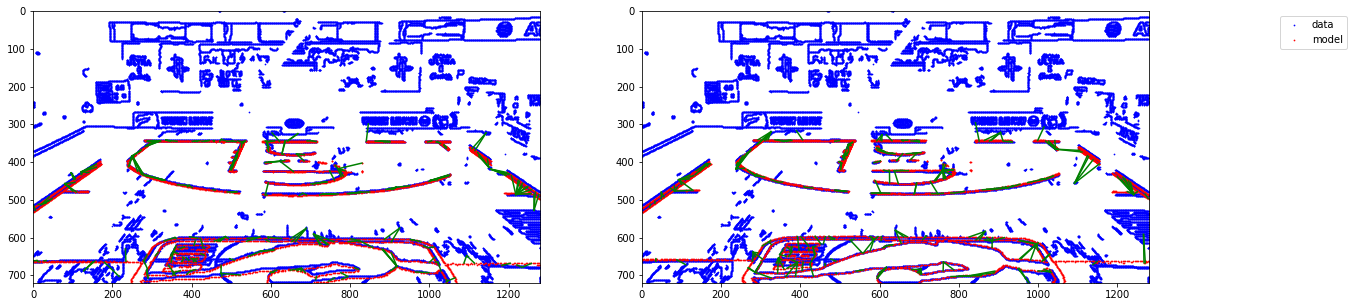

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

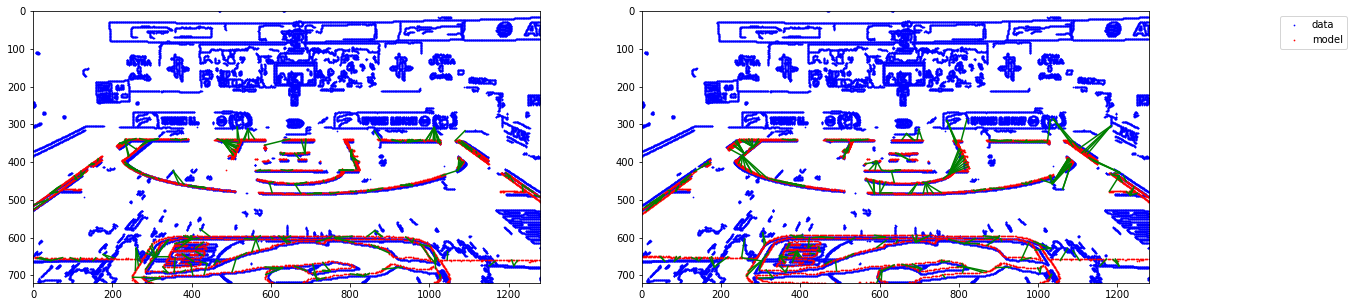

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

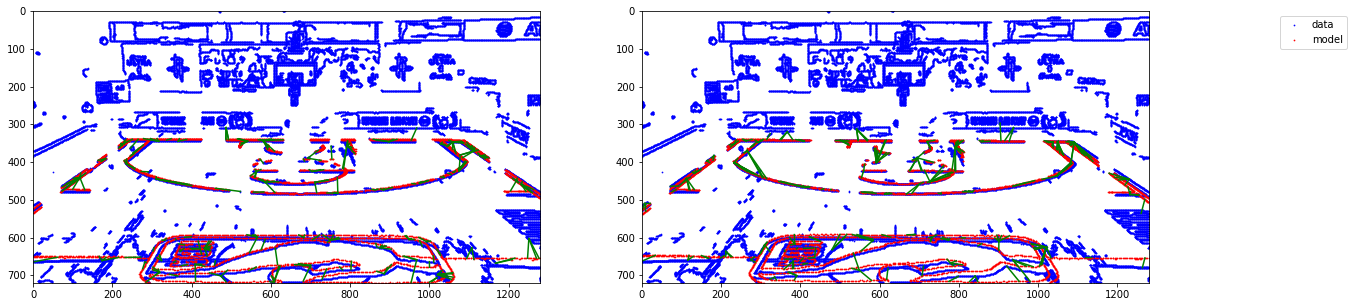

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

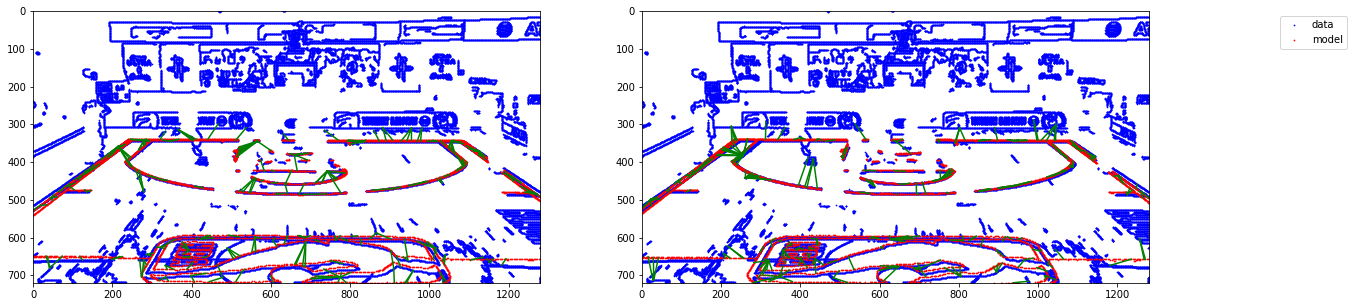

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

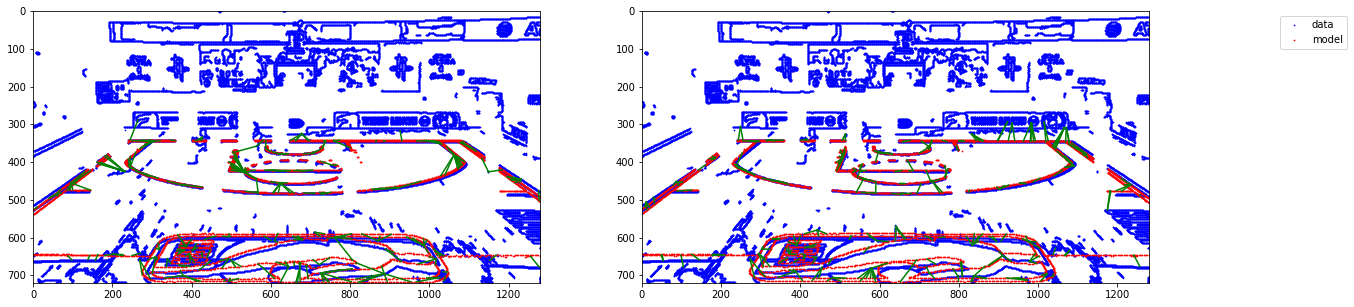

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

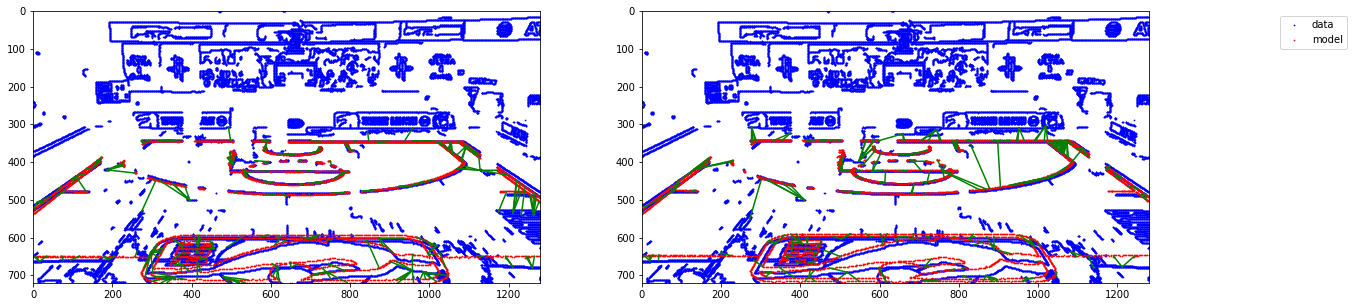

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  torch.Size([300, 2])
gt:  torch.Size([300, 2])
m:  t

In [233]:
# dofs_cam = []
for view_idx in np.arange(num_views)[2:]:
    print(f'VIEW {view_idx}')
    dofs_cam_view = []
    dofs_cam_i = torch.from_numpy(dofs_cam_0[view_idx, 0])
    for frame_idx in tqdm(range(num_frames)):
        img = img_proc.to_uint8(loader.load_data_imgs(VID_ROOT, [view_idx], [frame_idx])[0,0])
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         img = img_proc.process_img_canny(img, ep=True)
        img = img_proc.process_img_canny(img)
        img = img_proc.erase_players(img, kp[view_idx][frame_idx])
        if view_idx==0:
            img = img_proc.erase_scorebox(img, score_box)
        
        X_i_gt = np.stack(np.where(img>128)[::-1], axis=-1)
        X_i_gt = torch.from_numpy(X_i_gt)
        
        if frame_idx%15==0:
            plt.figure(figsize=(20, 5))
        dofs_cam_i = optimize_dofs(X_i_gt, X_w, dofs_cam_i, 
                                   kp[view_idx][frame_idx], (score_box if view_idx==0 else None), 
                                   show=frame_idx%15==0, lr=0.001)
        if frame_idx%15==0:
            plt.show()
        dofs_cam_view.append(dofs_cam_i)
    dofs_cam.append(torch.stack(dofs_cam_view))
dofs_cam = torch.stack(dofs_cam)

In [247]:
np.save(f'{VID_ROOT}/dofs_cam', dofs_cam.numpy())

In [ ]:
# ERASE PEOPLE IN MODEL IMAGE ALSO

In [82]:
import open3d as o3d

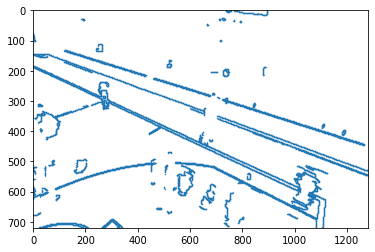

In [111]:
pc = X_i_gt.numpy()
plt.scatter(pc[:, 0], pc[:,1], s=0.1)
draw.set_img_bounds(img_shape_xy)

In [115]:
pc = np.concatenate([pc, np.zeros(pc.shape[:-1]+(1,))], axis=-1)

In [118]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc)

pcd.estimate_normals()

In [123]:
np.asarray(pcd.normals).std(axis=0)

array([0.        , 0.        , 0.82630808])

In [ ]:
dofs_cam_optim = dofs_cam_optim.detach()

In [ ]:
draw.show_cam_view(X_w, dofs_cam, label='ground truth')
draw.show_cam_view(X_w, dofs_cam_optim, label='initial')
plt.legend(bbox_to_anchor=(1.4, 1.))